<a href="https://colab.research.google.com/github/d-klotz/ai-training/blob/main/linear-regression-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Pandas library to load the dataset.


In [40]:
import pandas as pd

dataset = pd.read_csv("data/housing.csv")
dataset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Configurations
Let's make sure this notebook works fine with python 2 and 3. 
Matplotlit will be used for data visualization.

In [41]:
import numpy as np
np.random.seed(42)
import os

# used to plot the charts
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Knowing the dataset

In [42]:
# Displayes how many rows and columns are in the dataset
dataset.shape

(20640, 10)

In [43]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


total_bedrooms has 207 missing values.

ocean_proximity is of type text, let's check how many categorical values it has

In [44]:
set(dataset['ocean_proximity'])
dataset['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

Let's see some statistics about the numerical features

In [45]:
dataset.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Let's visualize the data to get a better understanding

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

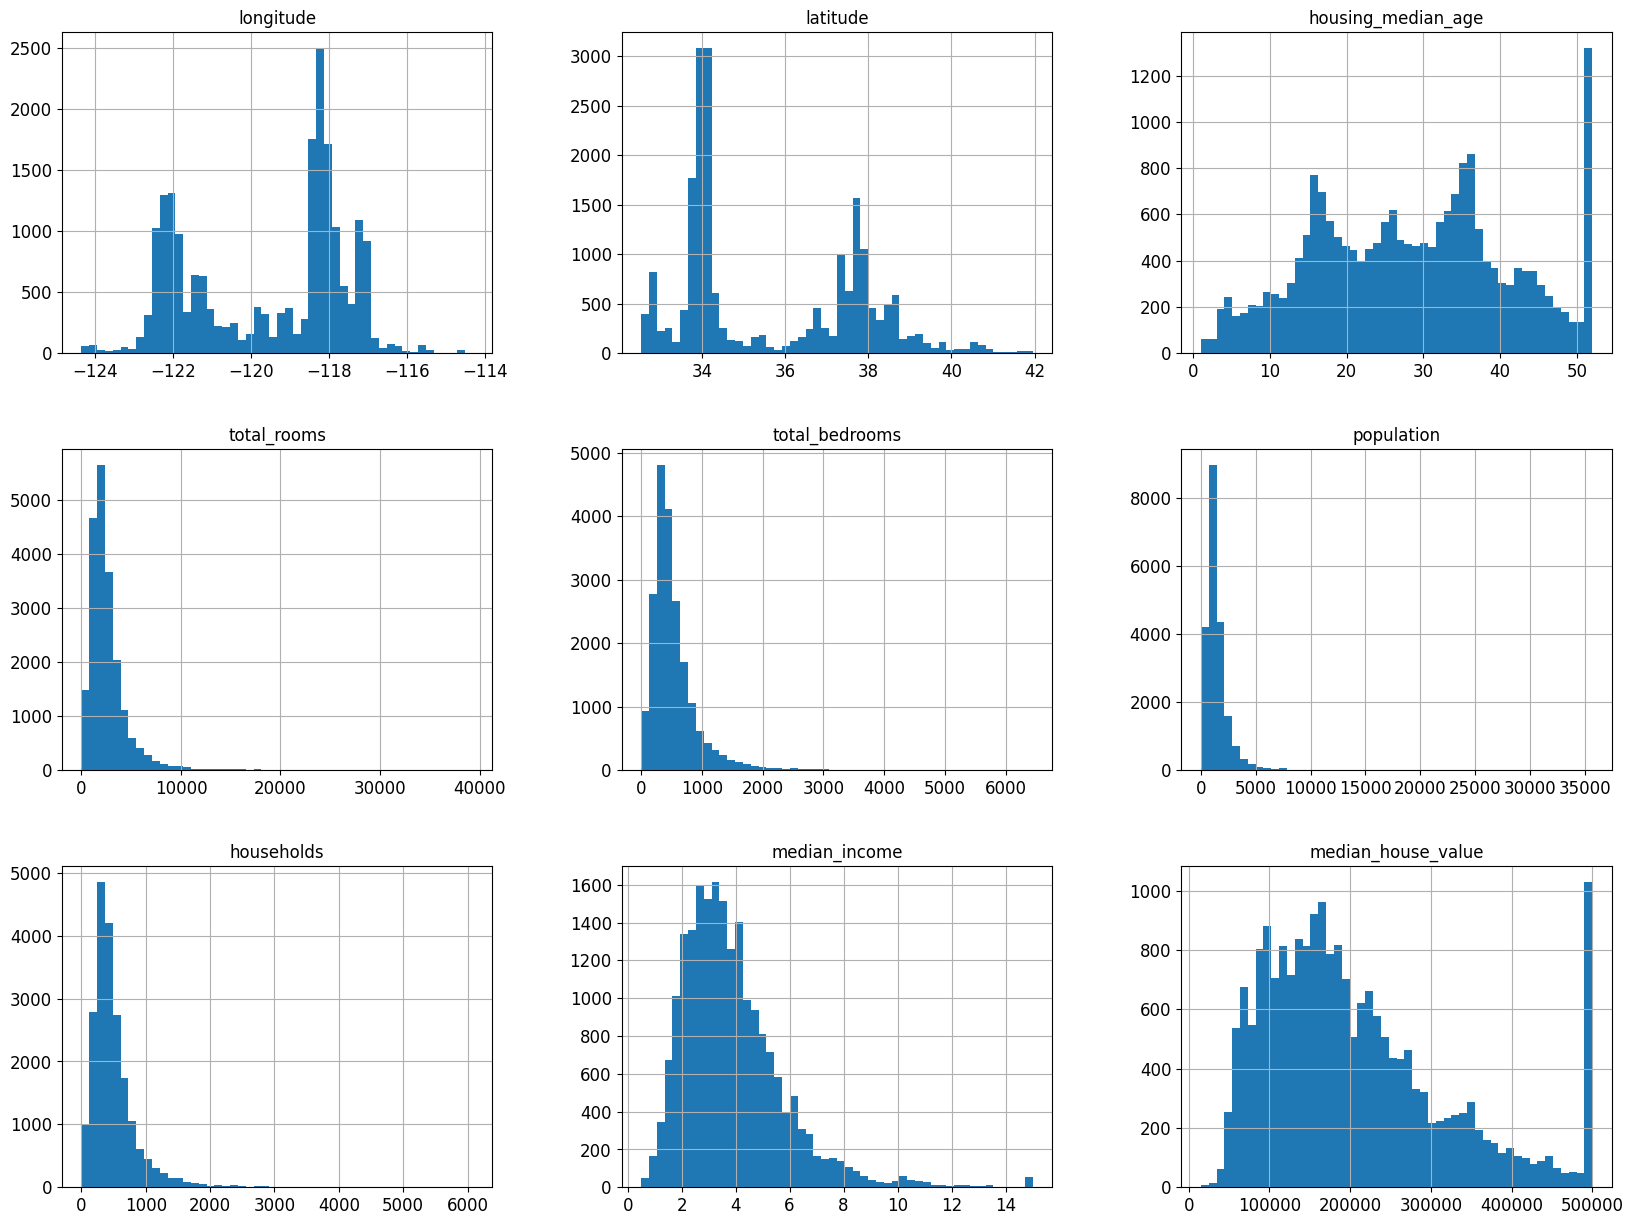

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
dataset.hist(bins=50, figsize=(20,15))

After checking the histograms, we notice that median income is capped at 15 and median house value is capped at 500,000. If we want to make predictions for houses above 500,000, we need to train our model with higher-priced data.

### Let's separate our databases into a training set and a test set.

In [47]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(dataset, test_size= 0.2, random_state=7)
print(len(df_train), "training", len(df_test), "testing")

16512 training 4128 testing


## Creating categories of median annual income
Let's suppose that we talked to a sales specialist and he said that median income is an important attribute to add to the predictive model. When we divide the dataset into training and testing sets, we need to make sure that the distribution of incomes in both sets is similar. We can achieve this by dividing the median income into categories.

<Axes: >

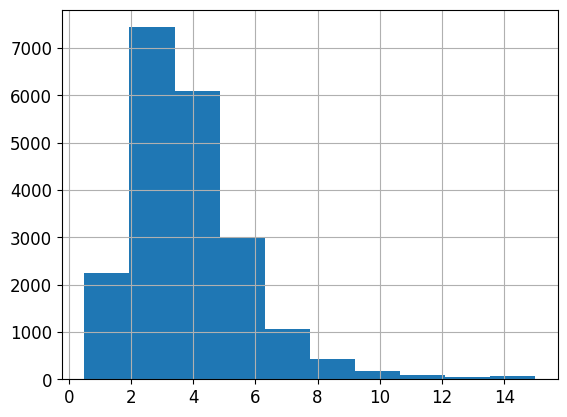

In [48]:
dataset['median_income'].hist()

Divide incomes into 5 categories by dividing the value of the column "median_income" by 1.5 and then rounding up to the nearest whole number. with np.ceil.

In [49]:
dataset['income_cat'] = np.ceil(dataset['median_income'] / 1.5)

Label those above 5 as 5 and those below 5 remains the same.

In [50]:
dataset['income_cat'].where(dataset['income_cat'] < 5, 5)

0        5.0
1        5.0
2        5.0
3        4.0
4        3.0
        ... 
20635    2.0
20636    2.0
20637    2.0
20638    2.0
20639    2.0
Name: income_cat, Length: 20640, dtype: float64

We can use the cut function from pandas to divide a set of intervaled data into bins.

In [51]:
dataset['income_cat'] = pd.cut(dataset['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
dataset['income_cat'].value_counts()

income_cat
3    7236
2    6581
4    3639
5    2362
1     822
Name: count, dtype: int64

<Axes: >

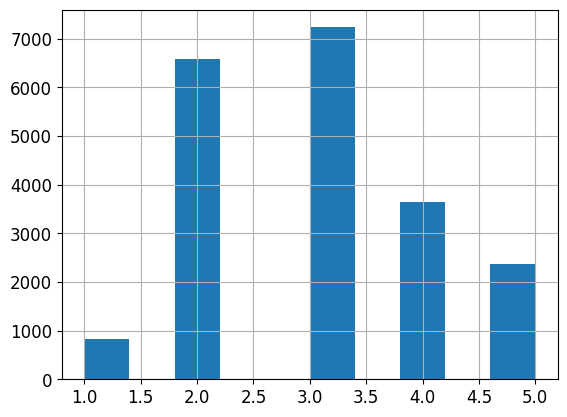

In [52]:
dataset['income_cat'].hist()

Now we can use stratified sampling to ensure that test and training sets have the same distribution of income categories. 

In [53]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(dataset, dataset['income_cat']):
    strat_train_set = dataset.loc[train_index]
    strat_test_set = dataset.loc[test_index]

In [54]:
#Let's check the distribution of income categories in the test set
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [55]:
#Let's check the distribution of income categories in the training set
strat_train_set['income_cat'].value_counts() / len(strat_train_set)

income_cat
3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: count, dtype: float64

In [ ]:
dataset['income_cat'].value_counts() / len(dataset)

After finishing stratified sampling, we can remove the income_cat column from the datasets because it's no longer needed, we only used it as an auxiliary variable for stratified sampling.'

In [56]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

### Analysing geographical data

<Axes: xlabel='longitude', ylabel='latitude'>

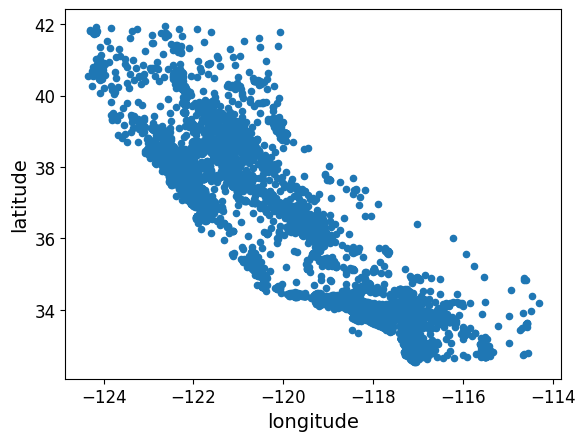

In [57]:
housing = strat_train_set.copy()

# The scatter plot will display almost a perfetc map of the California cities.
housing.plot(kind='scatter', x='longitude', y='latitude')

<Axes: xlabel='longitude', ylabel='latitude'>

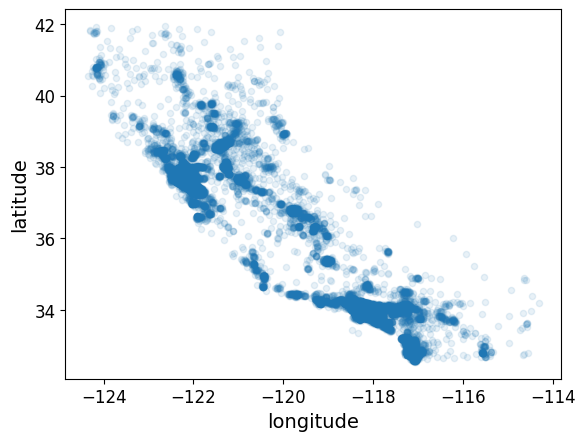

In [58]:
# This chart will display a density of the houses in the map.
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

Now let's plot the housing prices on the map and compare it with the density of houses.

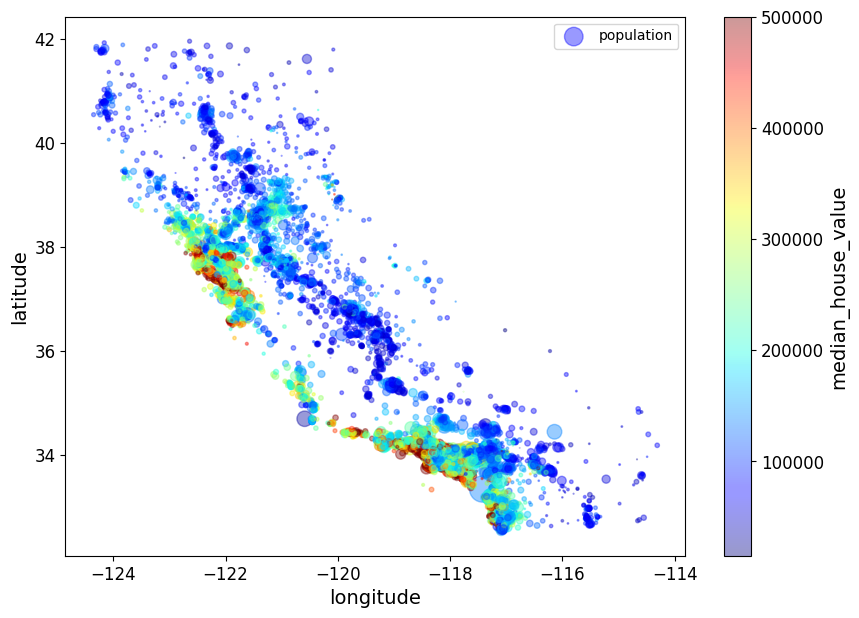

In [59]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
             s=housing['population']/100, label='population', figsize=(10,7),
             c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True,
             sharex=False)
plt.legend()

### Correlations
Now let's look at the correlations between the attributes.

In [60]:
corr_matrix = housing.corr()

ValueError: could not convert string to float: 'INLAND'

In [ ]:
# We can see that median house value is strongly correlated with median income
corr_matrix['median_house_value'].sort_values(ascending=False)